In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import os
import pandas as pd
from nltk.util import ngrams
from nltk import FreqDist
from collections import Counter
from nltk.tokenize import sent_tokenize
from collections import defaultdict
import json
from data_preprocess import *
import pickle
from gensim.parsing.preprocessing import remove_stopwords
from tqdm import tqdm,trange

#augment_data = pickle.load(open("extra_s2orc.pickle","rb"))
#for yr in range(1994,2022):
    #Data_Augmentation(year=yr)

def Build_mapping(year:str):
    '''
    Build index to word and word to index map for given year
    If year is not available, build map for entire corpus
    '''
    target_files = [x for x in os.listdir(data_path)]
    index2word={}
    word2index={}
    if year == "all":
        for f in target_files:
            temp = open(data_path+f,"r",encoding='utf-8').read()
            for word in temp.split():
                if word not in word2index:
                    word2index[word] = len(word2index)
                    index2word[len(word2index)-1] = word
    else:
        temp = open(data_path+f"{year}.txt","r",encoding='utf-8').read()
        for word in temp.split():
            if word not in word2index:
                word2index[word] = len(word2index)
                index2word[len(word2index)-1] = word

    return index2word, word2index

def Build_freq_dict(year:str):
    '''
    Build frequency dictionary for given year
    '''
    f = open(data_path+f"{year}.txt","r",encoding='utf-8').read()
    unigram = FreqDist(f.split())
    return unigram


def Get_Unigram(word:str, year:str):
    '''
    return frequency of a word in text from a given year
    '''
    f = open(data_path+f"{year}.txt","r",encoding='utf-8').read()
    unigram = FreqDist(f.split())
    return unigram[word] if word in unigram else 0

def Get_topk(k:int, year:str):
    '''
    Get top k common words in the text from given year
    '''
    f = open(data_path+f"{year}.txt","r",encoding='utf-8').read()
    freq = FreqDist(f.split())
    return freq.most_common(k)

def Get_sentences(year:str):
    '''
    get sentences from unprocessed data for a given year
    '''
    data = json.load(open(data_path+'unprocessed.json'))
    abstract = ""
    for record in data[year]:
        abstract += record["abstract"]
    sentences = sent_tokenize(abstract)
    
    for i in range(len(sentences)):
        sentences[i] = sentences[i].replace("\n"," ")
        temp = remove_punctuation(sentences[i])
        temp = to_lower_case(temp)
        temp = remove_stopwords(temp.split())
        temp = lemmatise_verbs(temp)
        temp = remove_numbers(temp)
        sentences[i] = " ".join(temp)
        
    for s in sentences:    
        if (not s) or (len(s.split())<2):
            sentences.remove(s)
    return sentences


def Data_Augmentation(year:int):

    file1 = open(f"./data/{year}.txt")
    lines = file1.read()
    extra = " ".join(augment_data[year])
    extra = remove_punctuation(extra)
    extra = to_lower_case(extra)
    extra = remove_stopwords(extra)
    extra = lemmatise_verbs(extra)
    extra = remove_numbers(extra)
    #lines += " "
    lines += ("".join(extra))
    out_file = open(f"./data_augmented/{year}.txt", "w",encoding='utf-8')
    out_file.write(lines)
    
    file1.close()
    out_file.close()

def Get_common_words(threshold):

    '''
    Get common words across all years and filter the words that have frequency more than threhold
    '''
    common_words = set([k for k, v in Build_freq_dict(year="1994").items() if v > threshold])
    for yr in trange(1995,2021):
        
        temp = [k for k, v in Build_freq_dict(year=f"{yr}").items() if v > threshold]
        common_words.intersection_update(temp)
    
    common_words = sorted(common_words)
    return common_words

def co_occurrence(sentences, window_size):
    '''
    Get co-occurence of words from string of sentences within the window_size
    '''
    d = defaultdict(int)
    vocab = set()

    text = sentences.split()
    for i in trange(len(text)):
        token = text[i]
        vocab.add(token)  
        next_token = text[i+1 : i+1+window_size]
        for t in next_token:
            key = tuple(sorted([t, token]))
            d[key] += 1
            
    vocab = sorted(vocab)  
    df = pd.DataFrame(data=np.zeros((len(vocab), len(vocab)), dtype=np.int16),
                      index=vocab,
                      columns=vocab)
    for key, value in d.items():
        df.at[key[0], key[1]] = value
        df.at[key[1], key[0]] = value
    
    df=df[list(common_words)]
    df=df.loc[df.index.isin(common_words)]
    
    return df

def construct_ppmi(df):
    '''
    construct ppmi based on co-occurence dataframe
    '''
    col_totals = df.sum(axis=0)
    total = col_totals.sum()
    row_totals = df.sum(axis=1)
    expected = np.outer(row_totals, col_totals) / total
    df = df / expected
    with np.errstate(divide='ignore'):
        df = np.log(df)
    df[np.isinf(df)] = 0.0  
    df[df < 0] = 0.0
    
    return df

def get_ppmi_embedding(year,window_size):
    '''
    get ppmi embedding for given word for the text in given year
    '''
    text = open(data_path+f"{year}.txt","r",encoding='utf-8').read()
    df_cooccurrence = co_occurrence(text, window_size=4)

    #from IPython.display import display, HTML
    #display(HTML(df_cooccurrence.to_html()))

    df_ppmi=construct_ppmi(df_cooccurrence).sort_index(ascending=True)
    df_ppmi = df_ppmi.reindex(sorted(df_ppmi.columns), axis=1)
    return df_ppmi

def get_nearest_neighbor(word,ppmi_matrix,k):
    # This is a helper function which gets k nearest neighbor words
    if (word not in common_words):
        return []
    
    matrix_year = []
    for wd in common_words:
        matrix_year.append(list(ppmi_matrix[wd]))
    matrix_year = np.array(matrix_year)

    knn_temp = NearestNeighbors(n_neighbors=k)
    knn_temp.fit(matrix_year)

    vector_temp = np.asarray(list(ppmi_matrix[word])).reshape(1, -1)
    neighbor_idx = knn_temp.kneighbors(vector_temp,k,return_distance=False)
    #print(neighbor_idx)
    
    ret = [common_words[i] for i in list(neighbor_idx)[0]]
    ret.remove(word)
    return ret

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\royxj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\royxj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\royxj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\royxj\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
data_path = "./data/"
Unique_Tokens=[]
list_yr=[]
for yr in trange(1994,2022):
    list_yr.append(yr)
    Unique_Tokens.append(len(Build_mapping(year=yr)[1]))
df_result=pd.DataFrame({"Year":list_yr,"Unique Tokens":Unique_Tokens})
df_result.set_index("Year",inplace=True)
df_result.plot(title="Unique Tokens",grid=True)

In [2]:
data_path = "./data_augmented/"
common_words=Get_common_words(threshold=20)
len(common_words)

100%|██████████| 26/26 [06:29<00:00, 15.00s/it]


6501

In [5]:
#ppmi_1994=get_ppmi_embedding(year=1994,window_size=4)
ppmi_2020=get_ppmi_embedding(year=2020,window_size=4)

100%|██████████| 3173119/3173119 [00:23<00:00, 137432.92it/s]


In [ ]:
#get_nearest_neighbor(word="deep",ppmi_matrix=ppmi_1994,k=6)
#get_nearest_neighbor(word="deep",ppmi_matrix=ppmi_2020,k=6)

In [28]:
#get_nearest_neighbor(word="corpora",ppmi_matrix=ppmi_1994,k=6)
get_nearest_neighbor(word="train",ppmi_matrix=ppmi_2020,k=20)

['model',
 'pre',
 'use',
 'learn',
 'propose',
 'task',
 'base',
 'language',
 'tune',
 'approach',
 'result',
 'fine',
 'neural',
 'art',
 'performance',
 'outperform',
 'multi',
 'paper',
 'improve']

In [ ]:
# get most and least changed context words
from scipy.spatial import distance
semantic_change = []
for word in common_words:
    embed_a = list(ppmi_1994[word])
    embed_b = list(ppmi_2020[word])
    cos_simi = distance.cosine(embed_a,embed_b)
    semantic_change.append(cos_simi)
[x for _,x in sorted(zip(semantic_change,common_words),reverse=False)][:12]

In [ ]:
distance.cosine(list(ppmi_1994["characterizations"]),list(ppmi_2020["characterizations"]))

In [3]:
import gensim.downloader
import pickle
import os
import psutil #This module helps in retrieving information on running processes and system resource utilization
from psutil import virtual_memory
import time #This module is used to calculate the time  
import warnings 
warnings.filterwarnings("ignore") 

# The following code is good for detect model memory usage and tiem to load  
process = psutil.Process(os.getpid())
mem = virtual_memory()

#Load W2V model. This will take some time, but it is a one time effort! 
pre = process.memory_info().rss
print("Memory used in GB before Loading the Model: %0.2f"%float(pre/(10**9))) #Check memory usage before loading the model
print('-'*10)

start_time = time.time() #Start the timer
ttl = mem.total #Toal memory available

#load the model
if os.path.isfile('nlp_w2v_googlenews300.pkl'):
    g300_vectors = pickle.load(open("nlp_w2v_googlenews300.pkl","rb"))
else:
    g300_vectors = gensim.downloader.load('word2vec-google-news-300')
    pickle.dump(g300_vectors, open("nlp_w2v_googlenews300.pkl","wb"))

print("%0.2f seconds taken to load"%float(time.time() - start_time)) #Calculate the total time elapsed since starting the timer
print('Finished loading Word2Vec')
post = process.memory_info().rss
print("Memory used in GB after Loading the Model: {:.2f}".format(float(post/(10**9)))) #Calculate the memory used after loading the model
print("Percentage increase in memory usage: {:.2f}% ".format(float((post/pre)*100))) #Percentage increase in memory after loading the model
print("Numver of words in vocablulary: ",len(g300_vectors.key_to_index.keys())) #Number of words in the vocabulary. 

Memory used in GB before Loading the Model: 0.27
----------
64.03 seconds taken to load
Finished loading Word2Vec
Memory used in GB after Loading the Model: 3.91
Percentage increase in memory usage: 1430.34% 
Numver of words in vocablulary:  3000000


In [4]:
from gensim.models.word2vec import Word2Vec
# The following code is good for detect model memory usage and tiem to load  
process = psutil.Process(os.getpid())
mem = virtual_memory()

#Load W2V model. This will take some time, but it is a one time effort! 
pre = process.memory_info().rss
print("Memory used in GB before Loading the Model: %0.2f"%float(pre/(10**9))) #Check memory usage before loading the model
print('-'*10)

start_time = time.time() #Start the timer
ttl = mem.total #Toal memory available

#load the model

trained_cs_vectors = Word2Vec.load("./model/2020.model")

print("%0.2f seconds taken to load"%float(time.time() - start_time)) #Calculate the total time elapsed since starting the timer
print('Finished loading Word2Vec')
post = process.memory_info().rss
print("Memory used in GB after Loading the Model: {:.2f}".format(float(post/(10**9)))) #Calculate the memory used after loading the model
print("Percentage increase in memory usage: {:.2f}% ".format(float((post/pre)*100))) #Percentage increase in memory after loading the model
print("Numver of words in vocablulary: ",len(trained_cs_vectors.wv.key_to_index.keys())) #Number of words in the vocabulary. 

Memory used in GB before Loading the Model: 3.75
----------
10.65 seconds taken to load
Finished loading Word2Vec
Memory used in GB after Loading the Model: 3.96
Percentage increase in memory usage: 105.39% 
Numver of words in vocablulary:  69592


In [32]:
WORD="train"
print(g300_vectors.most_similar(WORD, topn=10))
print(get_nearest_neighbor(word=WORD,ppmi_matrix=ppmi_2020,k=10))
print(trained_cs_vectors.wv.most_similar(WORD, topn=10))

[('trains', 0.8081232309341431), ('Train', 0.6729269623756409), ('commuter_train', 0.6523401737213135), ('locomotive', 0.6395583152770996), ('freight_train', 0.6207071542739868), ('railway', 0.6071821451187134), ('bus', 0.6067740321159363), ('Trains', 0.5963783264160156), ('rail', 0.5885170102119446), ('commuter_trains', 0.5821391940116882)]
['model', 'pre', 'use', 'learn', 'propose', 'task', 'base', 'language', 'tune']
[('initialize', 0.8524168729782104), ('pre', 0.8446813821792603), ('substitute', 0.8370950818061829), ('pseudo', 0.8242562413215637), ('unpaired', 0.8195383548736572), ('tune', 0.8185880184173584), ('scratch', 0.8175374269485474), ('freeze', 0.8033123016357422), ('pretraining', 0.8025900721549988), ('compress', 0.7985637187957764)]


In [31]:
WORD="data"
print(g300_vectors.most_similar(WORD, topn=10))
print(get_nearest_neighbor(word=WORD,ppmi_matrix=ppmi_2020,k=10))
print(trained_cs_vectors.wv.most_similar(WORD, topn=10))

[('Data', 0.7262316942214966), ('datasets', 0.603030264377594), ('dataset', 0.5796632170677185), ('databases', 0.5450120568275452), ('statistics', 0.537885844707489), ('information', 0.5368290543556213), ('database', 0.5325667262077332), ('Data_System_IPEDS', 0.5222618579864502), ('data.The', 0.5189104080200195), ('OpenSpirit_enabled', 0.5174090266227722)]
['model', 'paper', 'information', 'propose', 'approach', 'methods', 'use', 'proposed', 'performance']
[('stored', 0.8254101276397705), ('storing', 0.794579803943634), ('gathering', 0.7672482132911682), ('amounts', 0.7385837435722351), ('collection', 0.729941725730896), ('records', 0.7275473475456238), ('collecting', 0.7199752926826477), ('big', 0.7184199094772339), ('mined', 0.7163366079330444), ('streams', 0.7047645449638367)]


In [36]:
WORD="language"
print(g300_vectors.most_similar(WORD, topn=15))
print(get_nearest_neighbor(word=WORD,ppmi_matrix=ppmi_2020,k=10))
print(trained_cs_vectors.wv.most_similar(WORD, topn=10))

[('langauge', 0.7476695775985718), ('Language', 0.6695356369018555), ('languages', 0.6341332197189331), ('English', 0.6120712757110596), ('CMPB_Spanish', 0.6083105206489563), ('nonnative_speakers', 0.6063110828399658), ('idiomatic_expressions', 0.5889802575111389), ('verb_tenses', 0.5841569304466248), ('Kumeyaay_Diegueno', 0.5798824429512024), ('dialect', 0.5724600553512573), ('Amharic_Ethiopia', 0.57015061378479), ('vernacular_Leo', 0.5687463879585266), ('Euskera', 0.5647310018539429), ('Persian_Farsi', 0.5617388486862183), ('Python_programming', 0.5586454272270203)]
['model', 'task', 'use', 'natural', 'train', 'learn', 'pre', 'propose', 'base']
[('natural', 0.8305986523628235), ('computer', 0.8039324283599854), ('speak', 0.7833366394042969), ('translate', 0.7695532441139221), ('nlp', 0.7674071788787842), ('informal', 0.7588580250740051), ('nlu', 0.758335530757904), ('markup', 0.7546813488006592), ('formulaic', 0.7322909832000732), ('declarative', 0.7302923202514648)]


In [47]:
WORD="information"
print(g300_vectors.most_similar(WORD, topn=15))
print(get_nearest_neighbor(word=WORD,ppmi_matrix=ppmi_2020,k=10))
print(trained_cs_vectors.wv.most_similar(WORD, topn=10))

[('info', 0.7363681793212891), ('infomation', 0.680029571056366), ('infor_mation', 0.673384964466095), ('informaiton', 0.6639009118080139), ('informa_tion', 0.6601256728172302), ('informationon', 0.6339334845542908), ('informationabout', 0.6320980191230774), ('Information', 0.6186580657958984), ('informaion', 0.6093292236328125), ('details', 0.6063088774681091), ('inforamtion', 0.5957241654396057), ('Clorox_visit_www.TheCloroxCompany.com', 0.5866811275482178), ('please_visit_http://www.nyx.com', 0.5864027738571167), ('visit_http://www.sybase.com', 0.5852304100990295), ('visit_www.overlandstorage.com', 0.5848026871681213)]
['data', 'model', 'propose', 'use', 'paper', 'approach', 'task', 'methods', 'knowledge']
[('sensitive', 0.7092013955116272), ('data', 0.7004376649856567), ('geographic', 0.6983487010002136), ('content', 0.689644455909729), ('personal', 0.6846344470977783), ('context', 0.6784451007843018), ('contained', 0.676192045211792), ('metadata', 0.6727553009986877), ('relevant',

In [8]:
WORD="deep"
print(g300_vectors.most_similar(WORD, topn=25))
print(get_nearest_neighbor(word=WORD,ppmi_matrix=ppmi_2020,k=10))
print(trained_cs_vectors.wv.most_similar(WORD, topn=10))

[('deeper', 0.6928303241729736), ('deepest', 0.6820540428161621), ('depths', 0.53428715467453), ('shallow', 0.5275011658668518), ('gravelly_voice_fills', 0.5268532633781433), ('Deep', 0.5056449174880981), ('depth', 0.4998552203178406), ('deepening', 0.4924544095993042), ('Deeper', 0.49067163467407227), ('water_newbuilding_drillships', 0.48911160230636597), ('VATICAN_CITY_Dragged', 0.485953688621521), ('microbe_thrives', 0.4711202383041382), ('methane_hydrates_exist', 0.46659988164901733), ('fat_fryers', 0.4641149044036865), ('Janam_combines', 0.46373963356018066), ('Dan_Uggla_flyball', 0.4609009921550751), ('deeps', 0.45989763736724854), ('VirtualWisdom_virtual_infrastructure', 0.45106256008148193), ('fast_Yazel', 0.44914913177490234), ('acquire_BrownCo', 0.44796186685562134), ('DOUBLE_divan_bed', 0.44623351097106934), ('deepness', 0.4448399245738983), ('deepen', 0.44398951530456543), ('throated_roar', 0.4429834187030792), ('Qandil_mountains_straddling', 0.4428025484085083)]
['neural',

In [1]:
from gensim.models.word2vec import Word2Vec
cs_vectors = Word2Vec.load(f"./cs_model/1994.model")
cs_vectors_2 = Word2Vec.load(f"./cs_model/1995.model")


In [3]:
from scipy.spatial import distance
distance.cosine(cs_vectors.wv["deep"],cs_vectors_2.wv["deep"])

0.25539910793304443

In [7]:
from gensim.models.word2vec import Word2Vec
from scipy.spatial import distance
from tqdm import trange

year = []
cs_cosine_dis = []
chem_cosine_dis = []
eng_cosine_dis = []


for yr in trange(1994,2020):

    cs_vectors = Word2Vec.load(f"./cs_model/{yr}.model")
    cs_vectors_2 = Word2Vec.load(f"./cs_model/{yr+1}.model")

    chem_vectors = Word2Vec.load(f"./chem_model/{yr}.model")
    chem_vectors_2 = Word2Vec.load(f"./chem_model/{yr+1}.model")

    eng_vectors = Word2Vec.load(f"./eng_model/{yr}.model")
    eng_vectors_2 = Word2Vec.load(f"./eng_model/{yr+1}.model")
    

    year.append(yr)
    cs_cosine_dis.append(distance.cosine(cs_vectors.wv["research"],cs_vectors_2.wv["deep"]))
    chem_cosine_dis.append(distance.cosine(chem_vectors.wv["deep"],chem_vectors_2.wv["deep"]))
    eng_cosine_dis.append(distance.cosine(eng_vectors.wv["deep"],eng_vectors_2.wv["deep"]))


100%|██████████| 26/26 [14:07<00:00, 32.61s/it]


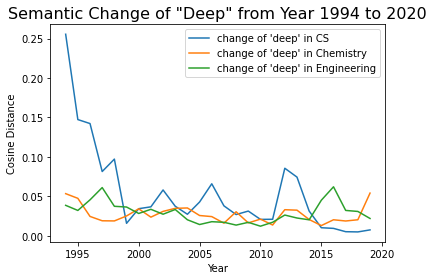

In [9]:
import matplotlib.pyplot as plt
  

# plot lines
plt.plot(year, cs_cosine_dis, label = "change of 'deep' in CS")
plt.plot(year, chem_cosine_dis, label = "change of 'deep' in Chemistry")
plt.plot(year, eng_cosine_dis, label = "change of 'deep' in Engineering")

plt.xlabel("Year")
plt.ylabel("Cosine Distance")
plt.title(f"Semantic Change of \"Deep\" from Year 1994 to 2020", fontsize=16)

plt.legend()
plt.show()